In [ ]:
from IPython.display import display, clear_output


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import P7_DataBreed
import p5_util

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from  sklearn import model_selection
import numpy as np


In [ ]:
import p5_util
filename= './data/df_breed_image.dump'
if False :
    df = p5_util.object_load(filename)
    df.shape

In [ ]:
import p5_util
if True :
    oP7_DataBreed = p5_util.object_load('./data/oP7_DataBreed.dump')
    oP7_DataBreed.show()

#### Build a sample dataset :

Sampling is leaded by 2 parameters :
* `breed_count` : number of breeds into the dataset
* `image_per_breed_count` : for each breed, number of image into sample.

In [ ]:
import P7_DataBreed

oP7_DataBreed=P7_DataBreed.P7_DataBreed('./data/Images')
oP7_DataBreed.std_size=None
oP7_DataBreed.is_squarred=False
oP7_DataBreed.is_kp_filtered=False
is_splitted=True
oP7_DataBreed.split_ratio=(3,3)
oP7_DataBreed.load()
breed_count=3
image_per_breed_count=100
list_breed_sample=['n02107142-Doberman','n02115641-dingo','n02113978-Mexican_hairless']
#list_breed_sample=['n02107142-Doberman']
oP7_DataBreed.list_breed_sample = list_breed_sample
oP7_DataBreed.sampling(breed_count, image_per_breed_count)

oP7_DataBreed.show()
oP7_DataBreed.show_breed_name()

**Execute following cell in order to update object version with no change in attributes**

* A backup instance of object is created. This backup instance is empty.
* If object instance is not defined then it is read from dmped file.
* object instance is copied back into backup instance
* Backup instance is deleted

In [ ]:
import P7_DataBreed
if True :
    oP7_DataBreed = P7_DataBreed.update_object_save(oP7_DataBreed, is_saved=False,is_new_attribute=True)
    oP7_DataBreed.show()


**Building Data-model**

DataFrame with columns as images, breed names and labels is built.

Labels are issued from encoding breed names. 

Labels are then used for training Keras network. 


In [ ]:
df = oP7_DataBreed.df_build()
df.label.unique(),df.shape

**Dataframe is saved**

In [ ]:
import p5_util

filename= './data/df_breed_image.dump'
p5_util.object_dump(df,filename)
df.sample()

### Image truncated against image resize

In [ ]:
ser_pil_image = df['image']
ser_label = df['label']

#### Original image sample

In [ ]:
pil_image = ser_pil_image.iloc[0]
print(pil_image.size)
pil_image

#### Resized image

Resize does not lead to loss of information due to truncation.
<br>
Resizing allows to consume less resources into CNN network.

In [ ]:
from PIL import Image
pil_image_square = pil_image.resize((224,224))
pil_image_square

#### Truncated image as square

### Building train and test sample, Keras compliant

In [ ]:
square = None
resize = (224,224)
test_size=0.1

In [ ]:
import P7_DataBreed

arr_keras_image_train, arr_keras_image_test, arr_label_train, arr_label_test \
= P7_DataBreed.p7_keras_X_train_test_build(ser_pil_image, ser_label, test_size=test_size, square=square, resize=resize)

arr_keras_image_train.shape, arr_keras_image_test.shape, arr_label_train.shape, arr_label_test.shape

#### Dump train and test sample

In [ ]:
import p5_util
filename='./data/arr_keras_X_y_train_test.dump'
p5_util.object_dump((arr_keras_image_train, arr_keras_image_test, arr_label_train, arr_label_test),filename)

## Building Sequential VGG16 network

#### Read dumped file for train and test sample

In [ ]:
import p5_util
filename='./data/arr_keras_X_y_train_test.dump'
(arr_X_train,arr_X_test, arr_y_train, arr_y_test) = p5_util.object_load(filename)
print(arr_X_train.shape,arr_X_test.shape,arr_y_train.shape,arr_y_test.shape)

### Building VGG16 Keras layers

#### 1st convolution layer is added 

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

my_VGG16 = Sequential()  # Création d'un réseau de neurones vide 

# Ajout de la première couche de convolution, suivie d'une couche ReLU
w=arr_X_train.shape[1]
h=arr_X_train.shape[2]
c=arr_X_train.shape[3]
print(w,h,c)
my_VGG16.add(Conv2D(64, (3, 3), input_shape=(w, h, c), padding='same', activation='relu'))
my_VGG16.add(Conv2D(64, (3, 3), activation='relu'))
my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#### 2nd convolution layer is added 

In [ ]:
# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
my_VGG16.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
my_VGG16.add(Conv2D(64, (3, 3), activation='relu'))
my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#### 3th convolution layer is added 

In [ ]:
# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
my_VGG16.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
my_VGG16.add(Conv2D(64, (3, 3), activation='relu'))
my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#### Pooling layer is added 

In [ ]:
nb_labels = arr_y_train.shape[0]
print("Number of labels for training process : "+str(nb_labels))
my_VGG16.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

#### 1st Dense layer is added

In [ ]:
my_VGG16.add(Dense(nb_labels, activation='relu'))

#### 2nd Dense layer is added

#### 3th Dense layer is added

In [ ]:
import numpy as np
# Ajout de la dernière couche fully-connected qui permet de classifier
my_VGG16.add(Dense(nb_labels, activation='softmax'))

#### VGG16 compilation

In [ ]:
from keras import optimizers
sgd = optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
rmsprop = optimizers.RMSprop(lr=1e-4)

#my_VGG16.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
#my_VGG16.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
my_VGG16.compile(optimizer=rmsprop, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


#### Keras Sequential model is dumped

In [ ]:
import p5_util
p5_util.object_dump(my_VGG16,'./data/VGG16Seq_rmsprop.dump')

In [ ]:
my_VGG16.summary()

## Loading VGG166 Sequential model

In [1]:
from IPython.display import display, clear_output


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import P7_DataBreed
import p5_util

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from  sklearn import model_selection
import numpy as np


In [2]:
import p5_util
if True :
    VGG16Seq = p5_util.object_load('./data/VGG16Seq_rmsprop.dump')
    VGG16Seq.summary()

import p5_util
import P7_DataBreed
if False :
    oP7_DataBreed = p5_util.object_load('./data/oP7_DataBreed.dump')
    oP7_DataBreed.show()
    oP7_DataBreed.breed_show()


p5_util.object_load : fileName= ./data/VGG16Seq_rmsprop.dump


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 111, 111, 64)      36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 54, 54, 64)        36928     
__________

## Test for images classification

#### Data is loaded form dumped file

In [3]:
import p5_util
filename='./data/arr_keras_X_y_train_test.dump'
(arr_X_train,arr_X_test, arr_y_train, arr_y_test) = p5_util.object_load(filename)
print(arr_X_train.shape,arr_X_test.shape,arr_y_train.shape,arr_y_test.shape)

#### Data normalization

arr_X_train = arr_X_train.astype('float32')
arr_X_test = arr_X_test.astype('float32')

# Scale the data to lie between 0 to 1
arr_X_train /= 255
arr_X_test /= 255

p5_util.object_load : fileName= ./data/arr_keras_X_y_train_test.dump
(270, 224, 224, 3) (30, 224, 224, 3) (270, 1) (30, 1)


#### Targets clases are one hot encoded

#### Model training

In [4]:
#for X_train, y_train in zip(list_X_train, list_y_train):
print(arr_X_train.shape)
#history = VGG16Seq.fit(arr_X_train, arr_y_train, epochs=3, batch_size=256, verbose=1)
history = VGG16Seq.fit(arr_X_train, arr_y_train, epochs=10, batch_size=90,verbose=1,validation_data=(arr_X_test, arr_y_test))

(270, 224, 224, 3)
Train on 270 samples, validate on 30 samples
Epoch 1/10
270/270 [==============================] - 23s 86ms/step - loss: 4.5948 - acc: 0.2481 - val_loss: 1.6964 - val_acc: 0.3000
Epoch 2/10
270/270 [==============================] - 23s 86ms/step - loss: 1.5102 - acc: 0.3259 - val_loss: 1.6796 - val_acc: 0.2333
Epoch 3/10
270/270 [==============================] - 23s 86ms/step - loss: 1.3934 - acc: 0.3704 - val_loss: 1.0858 - val_acc: 0.4667
Epoch 4/10
270/270 [==============================] - 23s 86ms/step - loss: 1.0660 - acc: 0.4889 - val_loss: 1.3471 - val_acc: 0.2333
Epoch 5/10
270/270 [==============================] - 23s 86ms/step - loss: 1.1919 - acc: 0.3815 - val_loss: 1.4942 - val_acc: 0.4333
Epoch 6/10
270/270 [==============================] - 23s 85ms/step - loss: 1.0963 - acc: 0.4630 - val_loss: 1.0478 - val_acc: 0.4333
Epoch 7/10
270/270 [==============================] - 69s 254ms/step - loss: 1.0216 - acc: 0.4667 - val_loss: 1.3505 - val_acc: 0.26

In [5]:
[test_loss, test_acc] = VGG16Seq.evaluate(arr_X_test, arr_y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

30/30 [==============================] - 2s 62ms/step
Evaluation result on Test Data : Loss = 1.1709071397781372, accuracy = 0.36666667461395264


Text(0.5, 1.0, 'Accuracy Curves')

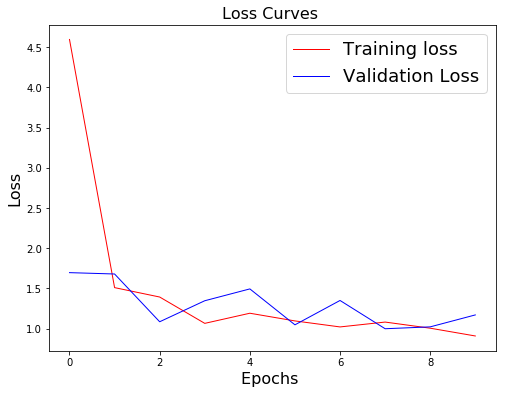

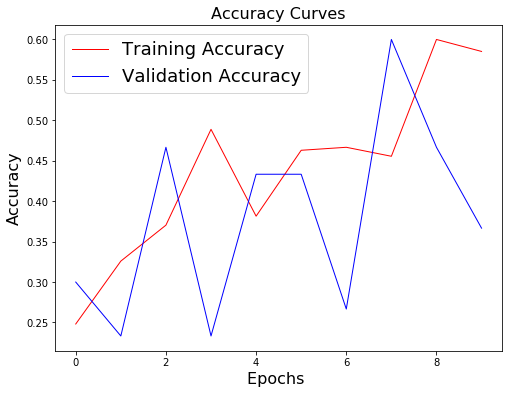

In [6]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=1.0)
plt.plot(history.history['val_loss'],'b',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves ',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=1.0)
plt.plot(history.history['val_acc'],'b',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
import p5_util
is_score_dumped=True
if is_score_dumped is True :
    filename = './data/dict_cls_score.dump'
    dict_cls_score = p5_util.object_load(filename)
else:
    dict_cls_score = dict()
dict_classifier = dict()

dict_cls_score

In [ ]:
y_pred = VGG16Seq.predict(arr_X_test)

In [ ]:
filename= './data/result_VGG16Seq.dump'
p5_util.object_dump(y_pred,filename)

#### Measure of accuracy

Result is stored into `arr_result` where :
* rows : number of observations from test dataset
* columns : probabibilty for each observation from train dataset.

For each row from `arr_result`, greater probability value is searched for. 
<br>
The result of search provides index of label into `list_index`.


In [ ]:
import p5_util
filename= './data/result_vgg16.dump'
p5_util.object_load(y_pred,filename)

In [ ]:
(loss, score_vgg16_seq) = VGG16Seq.evaluate(arr_X_test, arr_y_test, verbose=True)

score_vgg16_seq

In [ ]:
import pandas as pd
import p5_util
import p6_util_plot
is_dumped=True
if is_dumped is True:
    filename = './data/dict_cls_score.dump'
    dict_cls_score = p5_util.object_load(filename)
else :
    pass

dict_cls_score['VGG16 Seq'] = score_vgg16_seq
dict_benchmark_result = dict_cls_score.copy()

df_result = pd.DataFrame.from_dict( dict_benchmark_result, orient='index')
df_result.reset_index(inplace=True)
df_result.rename(columns={'index':'Classifier',0:'Score'}, inplace=True)
df_result
nb_images = oP7_DataBreed._sampling_breed_count*oP7_DataBreed._sampling_image_per_breed_count
nb_images = oP7_DataBreed.df_pil_image_kpdesc.shape[0]
if oP7_DataBreed.is_kp_filtered :
    title = "Benchmark classifiers accuracy / GMM clustering / "+str(nb_images)+" filtered splitted images / "+str(oP7_DataBreed.sampling_breed_count)+" breeds"
else :
    title = "Benchmark classifiers accuracy / GMM clustering / "+str(nb_images)+" splitted images / "+str(oP7_DataBreed.sampling_breed_count)+" breeds"

p6_util_plot.ser_item_occurency_plot(df_result.Classifier, df_result.Score*100, item_count=None, title=title,\
                                    p_reverse=False,p_x_title='Classifiers', p_y_title='Accuracy')

#### Classifier API
p5_util.object_dump(dict_cls_score,filename)

dict_cls_score

In [ ]:
oP7_DataBreed.show()
oP7_DataBreed.show_breed_name()